In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Rapidly Exploring Random Trees (RRT)

For more information:

* [Wikipedia](https://en.wikipedia.org/wiki/Rapidly-exploring_random_tree)
* [Modern Robotics Textbook](http://hades.mech.northwestern.edu/images/7/7f/MR.pdf)

This notebook shows how to code an RRT for a vehicle described by the SE2 group.

In [2]:
"""
These functions implement the SE2 Lie Group see (http://ethaneade.com/lie.pdf)
"""

def SE2_log(M):
    """
    Matrix logarithm for SE2 Lie group
    """
    theta = np.arctan2(M[1, 0], M[0, 0])
    if np.abs(theta) < 1e-6:
        A = 1 - theta**2/6 + theta**4/120
        B = theta/2 - theta**3/24 + theta**5/720
    else:
        A = np.sin(theta)/theta
        B = (1 - np.cos(theta))/theta
    V_inv = np.array([[A, B], [-B, A]])/(A**2 + B**2)
    t = M[:2, 2]
    u = V_inv.dot(t)
    return np.array([theta, u[0], u[1]])

def SE2_from_param(v):
    """
    Create SE2 from paramters, [theta, x, y]
    """
    theta, x, y = v
    return np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])

def SE2_to_param(M):
    """
    From matrix to [theta, x, y]
    """
    theta = np.arctan2(M[1, 0], M[0, 0])
    x = M[0, 2]
    y = M[1, 2]
    return np.array([theta, x, y])

def SE2_inv(M):
    """
    SE2 inverse
    """
    R = M[:2, :2]
    t = np.array([M[:2, 2]]).T
    return np.block([
        [R.T, -R.T.dot(t)],
        [0, 0, 1]
    ])

def SE2_exp(v):
    """
    SE2 matrix exponential
    """
    theta, x, y = v
    if np.abs(theta) < 1e-6:
        A = 1 - theta**2/6 + theta**4/120
        B = theta/2 - theta**3/24 + theta**5/720
    else:
        A = np.sin(theta)/theta
        B = (1 - np.cos(theta))/theta
    V = np.array([[A, -B], [B, A]])
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]])
    u = np.array([[x, y]]).T
    return np.block([
        [R, V.dot(u)],
        [0, 0,  1]])

v = np.random.randn(3)
X = SE2_from_param(v)
assert np.allclose(X.dot(SE2_inv(X)), np.eye(3))
assert np.allclose(SE2_log(SE2_exp(v)) - v, np.zeros(3))
assert np.allclose(SE2_to_param(SE2_from_param(v)) - v, np.zeros(3))

v = np.zeros(3)
X = SE2_from_param(v)
assert np.allclose(X.dot(SE2_inv(X)), np.eye(3))
assert np.allclose(SE2_log(SE2_exp(v)) - v, np.zeros(3))
assert np.allclose(SE2_to_param(SE2_from_param(v)) - v, np.zeros(3))

In [3]:
def sample(X_goal):
    """
    Sample from planning area [10, 10], [-5, 5],
    with 10% probability, return X_goal
    """
    x = 10*np.random.rand()
    y = 10*np.random.rand() - 5
    theta = 2*np.pi*np.random.rand()
    if np.random.rand() < 0.1:
        return X_goal
    else:
        return SE2_from_param([theta, x, y])

def distance(X0, X1):
    """
    Compute the distance from X0 to X1. There
    is a higher weight placed on cross-track movement (dy),
    as this is harder for the vehicle than turning (dtheta)
    and formward movingment (dx)
    """
    dtheta, dx, dy = SE2_log(SE2_inv(X0).dot(X1))
    cost = np.sqrt(dx**2 + 100*dy**2 + dtheta**2)
    
    # avoid moving backwards
    if dx < 0:
        cost *= 1000
        
    # avoid min turn radius
    if np.abs(dtheta) > 1e-3:
        R = dx/dtheta
        if np.abs(R) < 0.1:
            cost *= 1000
    return cost

def local_path_planner(X0, X1):
    """
    Plan a path from X0 to X1. If the norm of the lie algebra
    is greather than 1, limit it to 1.
    """
    v = SE2_log(SE2_inv(X0).dot(X1))
    if np.linalg.norm(v) > 1:
        v *= 1/np.linalg.norm(v)
    return X0.dot(SE2_exp(v))

def collision(collision_points, X0, X1, steps):
    """
    Check that the points along the trajectory from X0 to
    X1 do not collide with the circular collision points defined
    as a list of [x, y, r], where (x, y) is the center, and
    r is the radius. Evaluate the trajectory at (steps) discrete
    points.
    """
    v = SE2_log(SE2_inv(X0).dot(X1))
    for t in np.linspace(0, 1, steps):
        X = X0.dot(SE2_exp(v*t))
        theta, x, y = SE2_to_param(X)
        # check bounds of environment
        if (x < 0 or x > 10 or y < -5 or y > 5):
            return True
        for xc, yc, r in collision_points:
            if np.sqrt((xc - x)**2 + (yc - y)**2) < r:
                return True
    return False

In [4]:
class Tree:
    """
    This is a tree data structure that is used for RRT.
    Each tree has one parent, and a list of children.
    """
    
    def __init__(self, position):
        self.position = position
        self.parent = None
        self.children = []
    
    def add(self, child):
        """
        Add the child node to the tree.
        """
        child.parent = self
        self.children.append(child)
    
    def closest(self, position):
        """
        Find the node closest to the given position.
        """
        closest_node = self
        dist_min = distance(self.position, position)
        for child in self.children:
            child_closest, dist_child = child.closest(position)
            if dist_child < dist_min:
                closest_node = child_closest
                dist_min = dist_child
        return closest_node, dist_min

    def get_leaves(self):
        """
        Get all nodes (leaves) in the tree.
        """
        leaves = [self]
        for child in self.children:
            leaves.extend(child.get_leaves())
        return leaves

    def path(self):
        """
        Find the path from the root of the tree to the current node.
        """
        ret = [self]
        if self.parent is not None:
            ret = self.parent.path()
            ret.append(self)
        return ret

goal reached


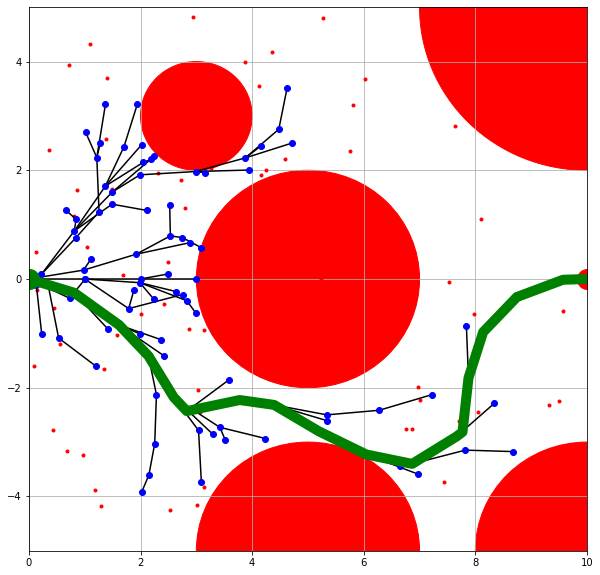

In [5]:
X_start = SE2_from_param([0, 0, 0])  # theta=0, x=0, y=0
X_goal = SE2_from_param([0, 10, 0])  # theta=0, x=10, y=0

# this is a list of all obstacles
# x, y, radius
collision_points = [
    [5, 0, 2],
    [3, 3, 1],
    [5, -5, 2],
    [10, 5, 3],
    [10, -5, 2],
]

root = Tree(X_start)
fig = plt.figure(figsize=(10, 10))
max_iterations = 200
i = 0
while True:
    
    # draw a random sample
    XS = sample(X_goal)
    
    # find the closest node to the sample
    node, dist = root.closest(XS)
    
    # avoid bad paths
    if dist > 10:
        continue
    
    # plan a path towards the sample from the closest node
    X0 = node.position
    X1 = local_path_planner(X0, XS)
    
    # if the path has a collision, skip
    if collision(collision_points, X0, X1, 10):
        continue
    
    # add the end of the local_path_planner path to the tree
    new_node = Tree(X1)
    node.add(new_node)
    
    # plot the tree
    p0 = SE2_to_param(node.position)
    p1 = SE2_to_param(new_node.position)
    ps = SE2_to_param(XS)
    plt.plot([p0[1], p1[1]], [p0[2], p1[2]], 'k-')
    plt.plot(ps[1], ps[2], 'r.')

    # check if we have reached the goal
    if distance(X1, X_goal) < 0.01:
        print('goal reached')
        break
    
    # check if we have exeeded max iterations
    i += 1
    if i > max_iterations:
        print('max iterations exceeded')
        break

# set the limits for the plot
plt.gca().set_xlim([0, 10])
plt.gca().set_ylim([-5, 5])
plt.grid()

# plot all nodes
for leaf in root.get_leaves():
    p = SE2_to_param(leaf.position)
    plt.plot(p[1], p[2], 'bo')

# plot the collision points
for x, y, r in collision_points:
    circle1 = plt.Circle((x, y), r, color='r')
    plt.gca().add_artist(circle1)

# plot the start and goal positions
xs = SE2_to_param(X_start)
xg = SE2_to_param(X_goal)
plt.plot(xs[1], xs[2], 'go', markersize=20)
plt.plot(xg[1], xg[2], 'ro', markersize=20)

# plot the path
path = np.array([SE2_to_param(n.position)[1:] for n in new_node.path()])
plt.plot(path[:, 0], path[:, 1], 'g-', linewidth=10)